# Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pprint import pprint

# Metric DataFrames

In [27]:
nmon_metric_options = [
    ("timestamp", "Timestamp MS since Epoch", [0, 80], "timestamp"), #0
    ("CPU_ALL:User%", "CPU Total: User %", [0,100], "cpu_all_user_percent"), # 1
    ("CPU_ALL:Sys%", "CPU Total: System %", [0,100], "cpu_all_system_percent"), # 2
    ("MEM:memtotal", "Memory MB: Total", [0,65000], "mem_MB_total"), #3
    ("MEM:hightotal", "Memory MB: High Total", [0,65000], "mem_MB_high_total"), #4
    ("MEM:lowtotal", "Memory MB: Low Total", [0,65000], "mem_MB_low_total"), #5
    ("MEM:swapfree", "Memory MB: Swap Free", [0,1000], "mem_MB_swap_free"), #6
    ("MEM:active", "Memory MB: Active", [0,65000], "mem_MB_active"), #7
    ("MEM:inactive", "Memory MB: Inactive", [0,65000], "mem_MB_inactive"), #8
    ("NET:eno1-write-KB/s", "Network Write KB/s", [0,1000], "net_io_write_KBps"), #9
    ("NET:eno1-read-KB/s", "Network Read KB/s", [0,1000], "net_io_read_KBps"), #10
    ("DISKBUSY:sda", "Disk Busy %: /dev/sda", [0,100], "disk_io_busy_percent"), #11
    ("DISKREAD:sda", "Disk Read KB/s: /dev/sda", [0,10000], "disk_io_read_KBps"), #12
    ("DISKWRITE:sda", "Disk Write KB/s: /dev/sda", [0,10000], "disk_io_write_KBps"), #13
    ("VM:pgfault", "Paging and Virtual Memory: Page Faults", [0,100], "virt_mem_page_faults") #14
]

free_mem_metrics = [
    ("total", "Memory Total", [0,67000], "mem_total_MB"), # 0
    ("used", "Memory Used", [0,67000], "mem_used_MB"), # 1
    ("free", "Memory Free", [0,67000], "mem_free_MB"), #2
    ("shared", "Memory Shared", [0,67000], "mem_shared_MB"), #3
    ("buff/cache", "Memory Buffer/Cache", [0,67000], "buff_cache_MB"), # 4
    ("available", "Memory Available", [0,67000], "mem_available_MB") # 5
]

possible_experiments = [
    "using_global_hp/synchronous"
]

experiments = [
    "using_global_hp/synchronous"
]

machine_names = [
    "ant",
    "antlion",
    "aphid",
    "assassin-bug",
    "bee",
    "centipede",
    "cockroach",
    "cricket",
    "damselfly",
    "deer-fly",
    "dragonfly"
]

CB_color_cycle = {
    "blue":'#377eb8',
    "orange":'#ff7f00',
    "green":'#4daf4a',
    "pink":'#f781bf',
    "brown":'#a65628',
    "purple":'#984ea3',
    "gray":'#999999',
    "red":'#e41a1c',
    "yellow":'#dede00'
}

chosen_metric = nmon_metric_options[1]
metric_header = chosen_metric[0]
metric_name = chosen_metric[1]
y_axis_limits = chosen_metric[2]
metric_file_suffix = chosen_metric[3]

experiment_dfs = []  # net read


for experiment in experiments:
    dataframes = []
    for i, hostname in enumerate(machine_names):
        filename = f"{i}-{hostname}.nmon.csv"
        #filename = f"{hostname}_free.csv"  # Switch these two if you want to look at free metrics
        filepath = f"{experiment}/{filename}"
        dataframe = pd.read_csv(filepath, header=0)
        dataframes.append(dataframe.pop(metric_header))
    experiment_dfs.append((experiment, dataframes))

# Cluster metrics

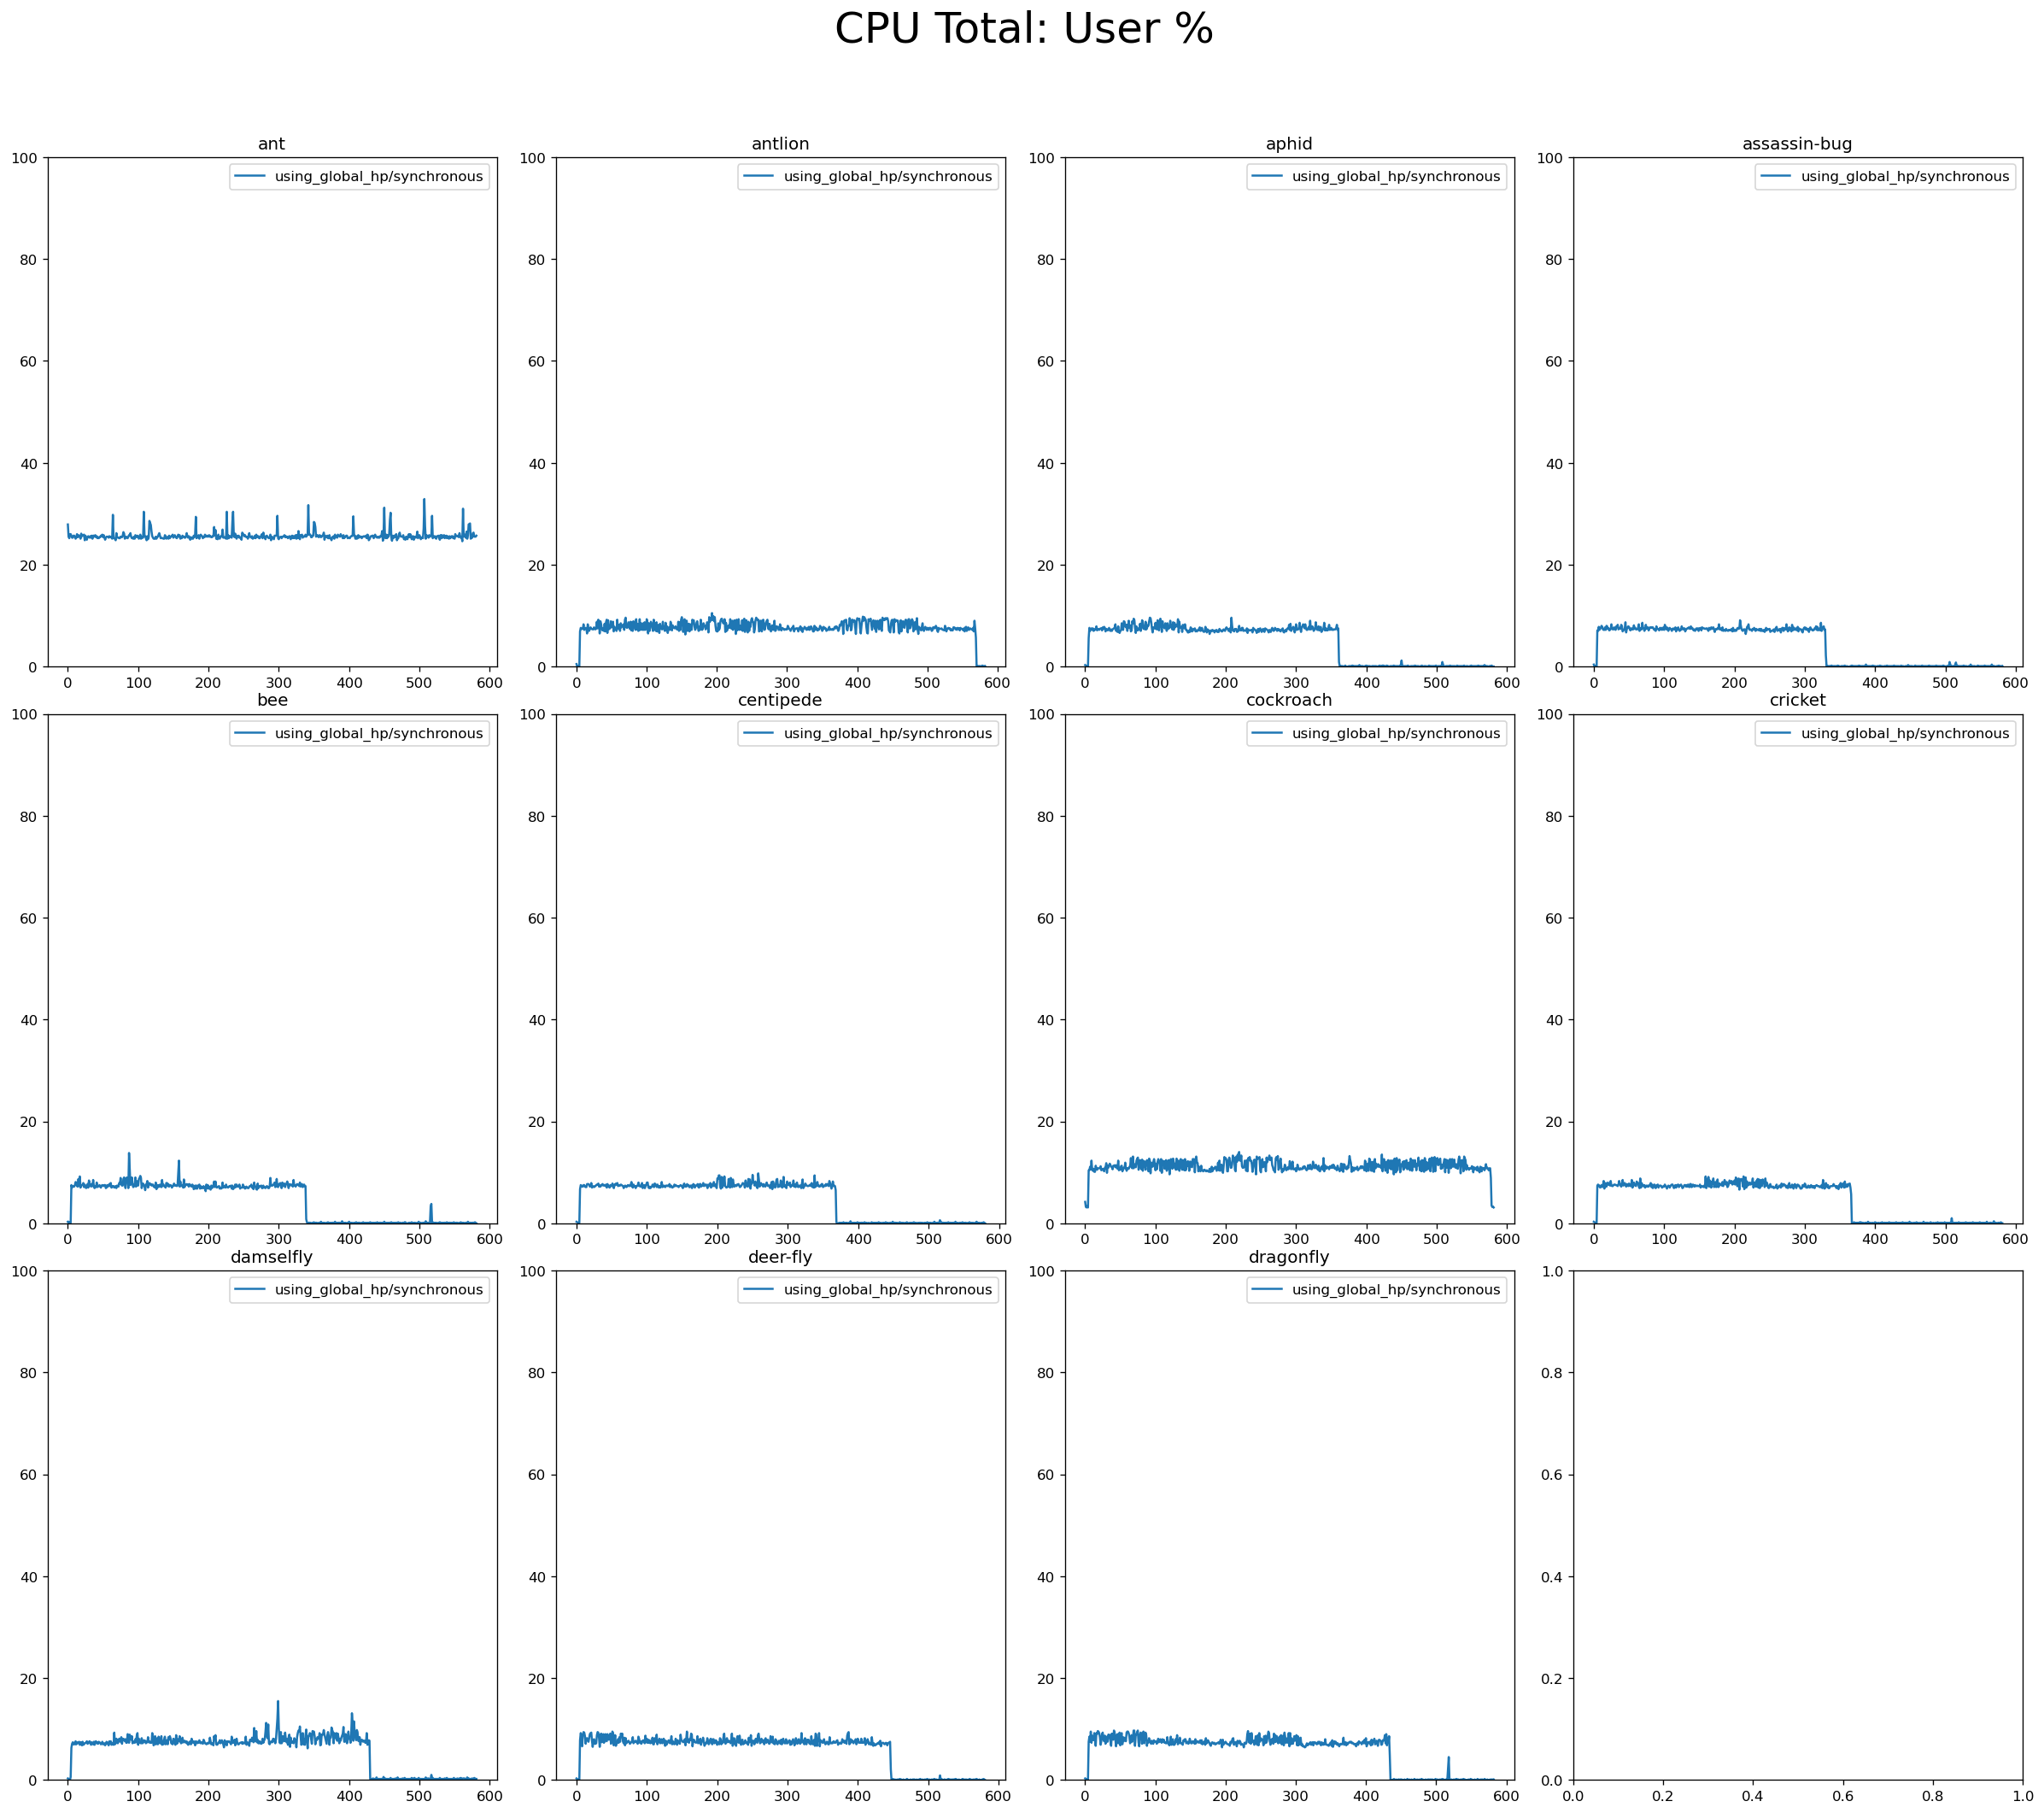

In [28]:
number_rows = 3
number_cols = 4

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(20, 18), dpi=120)
fig.tight_layout(h_pad=1.7)
fig.suptitle(metric_name, fontsize=30)

index = 0
for i in range(number_rows):
    for j in range(number_cols):
        if index == 11:
            break
        for experiment, dataframe in experiment_dfs:
            ax[i,j].set_ylim(y_axis_limits)
            ax[i,j].plot(dataframe[index], label=experiment)
            ax[i,j].set_title(machine_names[index])
            ax[i,j].legend()
        index += 1

plt.subplots_adjust(top=0.90)
plt.show()
#plt.savefig(f"{experiments[0]}/cluster_statistics_{metric_file_suffix}.png", dpi=300)

# Hyperparameter Search

In [29]:
# Find model with minimum val_loss
min_val_loss = 1.0
min_filename = ""
for filename in os.listdir("hp_search/"):
    if filename.endswith(".csv"):
        hp_df = pd.read_csv(f"hp_search/{filename}", header=0)
        min_of_column = hp_df["val_loss"].min()
        if min_of_column < min_val_loss:
            min_val_loss = min_of_column
            min_filename = filename

print(f"{min_filename}: {min_val_loss}")

run_25_64_64_64_0001.csv: 0.0009168281103484


# Global Validation vs Local Validation

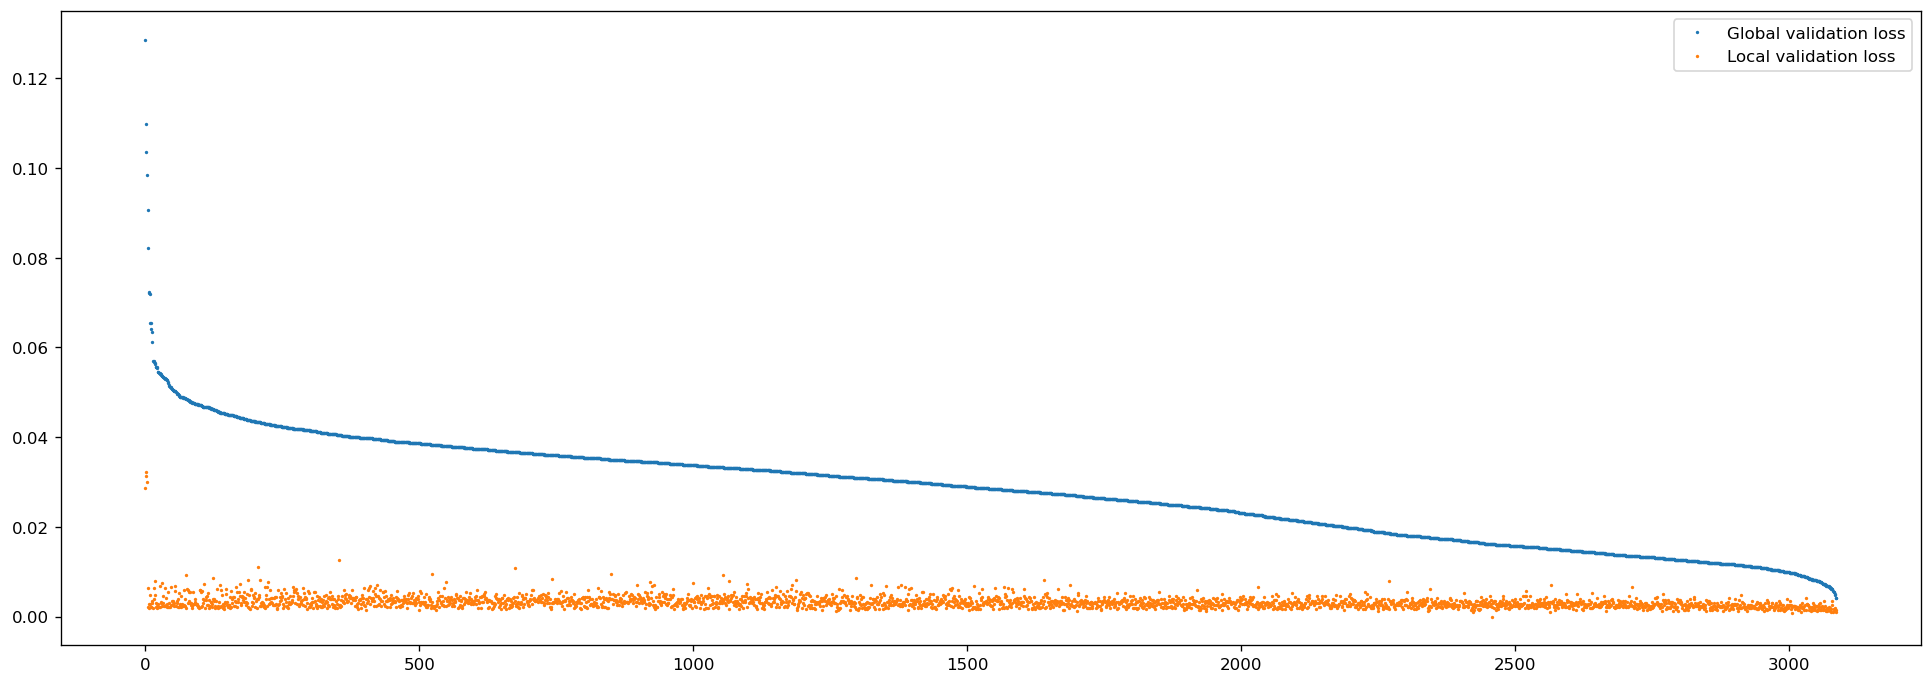

In [36]:
with open("using_global_hp/global_validation.json", "r") as f:
    global_model_response = json.load(f)

with open("using_global_hp/synchronous/response.json", "r") as f:
    local_model_response = json.load(f)

results = {}  # Mapping of gis_join -> (global_loss, local_loss)
for metric in global_model_response["metrics"]:
    gis_join = metric["gis_join"]
    results[gis_join] = [metric["loss"], 0.0]

for worker_response in local_model_response["worker_responses"]:
    for metric in worker_response["validation_metrics"]:
        gis_join = metric["gis_join_metadata"]["gis_join"]
        results[gis_join][1] = metric["true_loss"]

as_list = list(results.values())
as_list.sort(key=lambda y: y[0], reverse=True)
global_loss_vals = [x[0] for x in as_list]
local_loss_vals = [x[1] for x in as_list]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7), dpi=120)

ax.plot(global_loss_vals, '.', ms=2, label="Global validation loss")
ax.plot(local_loss_vals, '.', ms=2, label="Local validation loss")
ax.legend()
plt.show()